In [17]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fabiobasson","key":"d71cbfdfd23379909173204eac74cf96"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download phylake1337/fire-dataset

 99% 385M/387M [00:09<00:00, 43.4MB/s]
100% 387M/387M [00:09<00:00, 44.2MB/s]


In [18]:
!unzip -qq fire-dataset.zip

### Data Preprocessing

In [5]:
fire_dir = glob.glob('fire_dataset/fire_images/*.png')
non_fire_dir = glob.glob('fire_dataset/non_fire_images/*.png')

fire_dir

['fire_dataset/fire_images/fire.59.png',
 'fire_dataset/fire_images/fire.601.png',
 'fire_dataset/fire_images/fire.433.png',
 'fire_dataset/fire_images/fire.121.png',
 'fire_dataset/fire_images/fire.671.png',
 'fire_dataset/fire_images/fire.685.png',
 'fire_dataset/fire_images/fire.156.png',
 'fire_dataset/fire_images/fire.249.png',
 'fire_dataset/fire_images/fire.382.png',
 'fire_dataset/fire_images/fire.418.png',
 'fire_dataset/fire_images/fire.459.png',
 'fire_dataset/fire_images/fire.633.png',
 'fire_dataset/fire_images/fire.322.png',
 'fire_dataset/fire_images/fire.722.png',
 'fire_dataset/fire_images/fire.507.png',
 'fire_dataset/fire_images/fire.327.png',
 'fire_dataset/fire_images/fire.664.png',
 'fire_dataset/fire_images/fire.506.png',
 'fire_dataset/fire_images/fire.739.png',
 'fire_dataset/fire_images/fire.470.png',
 'fire_dataset/fire_images/fire.711.png',
 'fire_dataset/fire_images/fire.242.png',
 'fire_dataset/fire_images/fire.536.png',
 'fire_dataset/fire_images/fire.377

In [6]:
fire_df = []
non_fire_df = []
for i in fire_dir:
    fire_df.append([i,'fire'])
for j in non_fire_dir:
    non_fire_df.append([j,'non-fire'])
df = fire_df + non_fire_df
random.shuffle(df)

In [7]:
print (df)

[['fire_dataset/non_fire_images/non_fire.195.png', 'non-fire'], ['fire_dataset/fire_images/fire.755.png', 'fire'], ['fire_dataset/fire_images/fire.249.png', 'fire'], ['fire_dataset/fire_images/fire.590.png', 'fire'], ['fire_dataset/fire_images/fire.289.png', 'fire'], ['fire_dataset/non_fire_images/non_fire.107.png', 'non-fire'], ['fire_dataset/fire_images/fire.359.png', 'fire'], ['fire_dataset/fire_images/fire.56.png', 'fire'], ['fire_dataset/fire_images/fire.694.png', 'fire'], ['fire_dataset/fire_images/fire.111.png', 'fire'], ['fire_dataset/non_fire_images/non_fire.100.png', 'non-fire'], ['fire_dataset/fire_images/fire.573.png', 'fire'], ['fire_dataset/fire_images/fire.43.png', 'fire'], ['fire_dataset/fire_images/fire.714.png', 'fire'], ['fire_dataset/fire_images/fire.544.png', 'fire'], ['fire_dataset/non_fire_images/non_fire.70.png', 'non-fire'], ['fire_dataset/non_fire_images/non_fire.176.png', 'non-fire'], ['fire_dataset/non_fire_images/non_fire.106.png', 'non-fire'], ['fire_datas

In [8]:
data_df = pd.DataFrame(df, columns = ['path','label'])
print (data_df)

                                              path     label
0    fire_dataset/non_fire_images/non_fire.195.png  non-fire
1            fire_dataset/fire_images/fire.755.png      fire
2            fire_dataset/fire_images/fire.249.png      fire
3            fire_dataset/fire_images/fire.590.png      fire
4            fire_dataset/fire_images/fire.289.png      fire
..                                             ...       ...
994          fire_dataset/fire_images/fire.410.png      fire
995   fire_dataset/non_fire_images/non_fire.51.png  non-fire
996          fire_dataset/fire_images/fire.354.png      fire
997   fire_dataset/non_fire_images/non_fire.12.png  non-fire
998          fire_dataset/fire_images/fire.538.png      fire

[999 rows x 2 columns]


In [47]:
!rm -rf fire_dataset/fire_images/non_fire_images/* 

In [86]:
! rm -rf new_fire_dataset/

In [46]:
! cp -rf fire_dataset/fire_images/non_fire_images/* 

In [85]:
import os, shutil, pathlib

original_dir = pathlib.Path("fire_dataset/fire_images")
new_base_dir = pathlib.Path("new_fire_dataset")

def make_subset(subset_name, start_index, end_index):
    for category in ("fire", "no_fire"):
        dir = new_base_dir / subset_name 
        os.makedirs(dir)
        fnames = [f"{category}.{i}.png" for i in range(start_index, end_index)]
        for fname in fnames:
          shutil.copyfile(src=original_dir / fname ,dst=dir / fname)

make_subset("train", start_index=1, end_index=300)
make_subset("validation", start_index=300, end_index=500)
make_subset("test", start_index=500, end_index=1000)

FileExistsError: ignored

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

validation_generator =  test_datagen.flow_from_directory( "cats_and_dogs/dataset/test_set/",
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

In [87]:
datagen = ImageDataGenerator(rescale=1./255,
                            #rotation_range = 40,
                            #width_shift_range = 0.2,
                            #height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True)

In [89]:
train_generator = datagen.flow_from_directory("fire_dataset/fire_images/",
                                             target_size=(256,256),
                                              class_mode='binary',
                                              )


Found 0 images belonging to 1 classes.


In [ ]:
validation_generator = datagen.flow_from_dataframe(data_df,
                                                   x_col='path',
                                                   y_col='label',
                                                   images_size=(256,256),
                                                   class_mode='binary',
                                                   subset='validation')

### InceptionV3

In [ ]:
inception_v3 = InceptionV3(input_shape=(256,256,3),
                           weights='imagenet',
                           include_top=False)
inception_v3.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu', input_shape=(256,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

#x = layers.Flatten()(inception_v3.output)
#x = layers.BatchNormalization()(x)
#x = layers.Dense(1024,activation='relu')(x)
#x = layers.Dropout(0.2)(x)                  
#x = layers.Dense(1,activation='sigmoid')(x)           

#model1 = Model(inception_v3.input, x) 

model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model.fit_generator(train_generator,
                               epochs=50,
                               verbose=0,
                               validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


KeyboardInterrupt: ignored

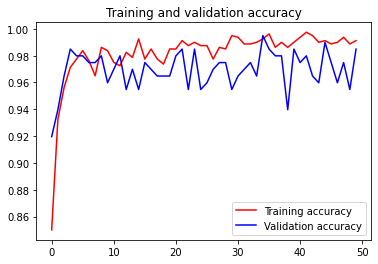

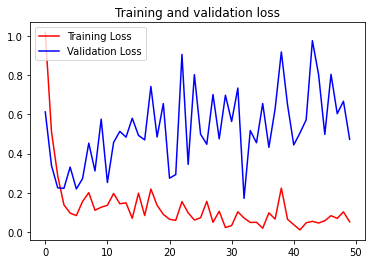

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc1 = model1.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc1))

7/7 [==============================] - 8s 1s/step - loss: 0.7592 - acc: 0.9749
validation_accuracy: 0.9748743772506714


### EfficientNet B0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
efficientnet_b0 = EfficientNetB0(include_top=False,
                             weights="imagenet",
                             input_shape=(256,256,3))
efficientnet_b0.trainable = False

In [ ]:
x = layers.Flatten()(efficientnet_b0.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation='sigmoid')(x)           

model2 = Model(efficientnet_b0.input, x) 

model2.compile(optimizer = Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model2.fit_generator(train_generator,
                               epochs=50,
                               verbose=0,
                               validation_data=validation_generator)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc2 = model2.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc2))

### EfficientNet B7

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

In [ ]:
efficientnet_b7 = EfficientNetB7(include_top=False,
                                 weights="imagenet",
                                 input_shape=(256,256,3))
efficientnet_b7.trainable = False

In [ ]:
x = layers.Flatten()(efficientnet_b7.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation='sigmoid')(x)           

model3 = Model(efficientnet_b7.input, x) 

model3.compile(optimizer = Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model3.fit_generator(train_generator,epochs=50,
                               verbose=0,
                               validation_data=validation_generator)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc3 = model3.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc3))

### Model Comparison

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [val_acc1,val_acc2,val_acc3]
model = ['InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()